# Exploring the results from Spark
Spark is powerful, but doesn't really provide as many tools for metrics and model evaluation as Python. Wrangling the data back from DataBricks turned out to be a pain... but here it is!

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC

from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [71]:
df = pd.read_csv('../assets/data/merged_rawPredictions.csv')

In [72]:
df.head()

,"{""added"":[""part-00000-tid-8086206716274430561-5d947a8e-6803-4ee8-a0ac-72f329fa7141-2406-c000.csv""",part-00001-tid-8086206716274430561-5d947a8e-6803-4ee8-a0ac-72f329fa7141-2407-c000.csv,part-00002-tid-8086206716274430561-5d947a8e-6803-4ee8-a0ac-72f329fa7141-2408-c000.csv,part-00003-tid-8086206716274430561-5d947a8e-6803-4ee8-a0ac-72f329fa7141-2409-c000.csv],removed:[]}286,0.0,0,0.8553257800650063,-0.8553257800650063
0,289,0.0,0,0.423098,-0.423098,NaN,NaN,NaN,NaN
1,292,0.0,0,0.498143,-0.498143,NaN,NaN,NaN,NaN
2,436,0.0,0,0.950636,-0.950636,NaN,NaN,NaN,NaN
3,442,0.0,0,0.582689,-0.582689,NaN,NaN,NaN,NaN
4,475,0.0,0,1.057223,-1.057223,NaN,NaN,NaN,NaN


In [73]:
df.columns = ['index', 'y_hat', 'y_true', 'prob_0', 'prob_1', 'x','c','v','b']

In [74]:
df.head()

,index,y_hat,y_true,prob_0,prob_1,x,c,v,b
0,289,0.0,0,0.423098,-0.423098,NaN,NaN,NaN,NaN
1,292,0.0,0,0.498143,-0.498143,NaN,NaN,NaN,NaN
2,436,0.0,0,0.950636,-0.950636,NaN,NaN,NaN,NaN
3,442,0.0,0,0.582689,-0.582689,NaN,NaN,NaN,NaN
4,475,0.0,0,1.057223,-1.057223,NaN,NaN,NaN,NaN


In [75]:
df = df[['index', 'y_hat', 'y_true', 'prob_0', 'prob_1']]

In [76]:
df.index = df['index'].values

In [77]:
df.drop('index', axis = 1, inplace = True)

In [78]:
df.columns = df.columns.get_level_values(0)

In [79]:
df.head(20)

,y_hat,y_true,prob_0,prob_1
289,0.0,0,0.423098,-0.423098
292,0.0,0,0.498143,-0.498143
436,0.0,0,0.950636,-0.950636
442,0.0,0,0.582689,-0.582689
475,0.0,0,1.057223,-1.057223
545,0.0,0,0.574421,-0.574421
730,0.0,0,0.873808,-0.873808
739,0.0,0,1.418174,-1.418174
852,0.0,0,1.085413,-1.085413
860,0.0,0,0.931246,-0.931246


## Evaluating
Now that the data is in a Pandas-friendly format, let's use some metrics!

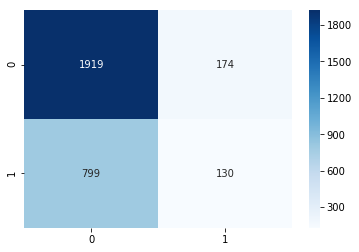

In [80]:
sns.heatmap(confusion_matrix(df['y_true'], df['y_hat']), fmt = 'g', annot = True, cmap = 'Blues')

Not super inspiring. To see how this compares to the baseline, the Cohen-Kappa Statistic is a useful measure.  
  
$$\kappa = (p_o - p_e)/(1 - p_e) $$  
where $p_o$ is the observed label percentage, and $p_e$ is the percentage that would occur by chance.
Using this statistic, 0 is the baseline.

In [82]:
cohen_kappa_score(df['y_true'], df['y_hat'])

0.069872653413444064

Better than the baseline!

Another metric (in fact the one used by Spark) is the area under the ROC curve. It's good to be over .5.

In [87]:
mn = df['prob_1'].min() 
mx = df['prob_1'].max()

df['proba'] = (df['prob_1'] - mn)/(mx - mn)

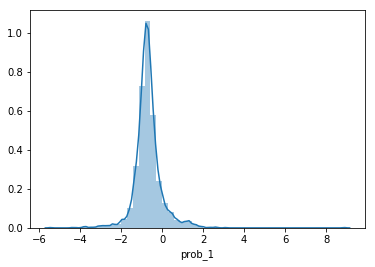

In [30]:
sns.distplot(df['prob_1'])

In [88]:
odds = np.exp(df['prob_1'])

In [89]:
df['proba'] = odds / (1 + odds)

In [90]:
fpr, tpr, _ = roc_curve(df['y_true'], df['proba'])

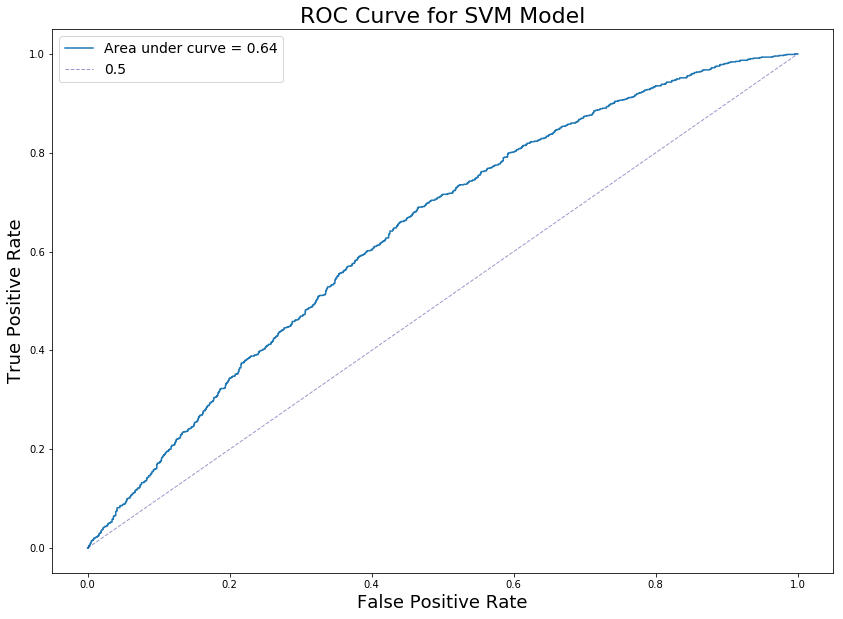

In [91]:
plt.figure(figsize = (14,10))
plt.plot(fpr, tpr, label = "Area under curve = 0.64")
plt.title("ROC Curve for SVM Model", fontsize = 22)
plt.xlabel("False Positive Rate", fontsize = 18)
plt.ylabel("True Positive Rate", fontsize = 18)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=  0.4, label = "0.5")
plt.legend(fontsize = 14)
plt.savefig("../assets/visualizations/roc.png")

### This suggests a threshold such that the true positive rate is high (0.8) and the false positive rate is relatively low (0.6)